In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# ============================================================
# Arabic Sentiment Analysis — Kaggle Notebook
# CountVectorizer | TF-IDF | N-grams | 10+ ML Models Comparison
# ============================================================

import numpy as np
import pandas as pd
import re
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


In [4]:
import pandas as pd
import os


base_path = "/kaggle/input/arabic-sentiment-twitter-corpus"


positive_train = pd.read_csv(os.path.join(base_path, "train_Arabic_tweets_positive_20190413.tsv"), sep="\t", header=None, names=["tweet"])
negative_train = pd.read_csv(os.path.join(base_path, "train_Arabic_tweets_negative_20190413.tsv"), sep="\t", header=None, names=["tweet"])
positive_test  = pd.read_csv(os.path.join(base_path, "test_Arabic_tweets_positive_20190413.tsv"), sep="\t", header=None, names=["tweet"])
negative_test  = pd.read_csv(os.path.join(base_path, "test_Arabic_tweets_negative_20190413.tsv"), sep="\t", header=None, names=["tweet"])


positive_train["sentiment"] = "positive"
negative_train["sentiment"] = "negative"
positive_test["sentiment"]  = "positive"
negative_test["sentiment"]  = "negative"


df = pd.concat([positive_train, negative_train, positive_test, negative_test], ignore_index=True)



print("Shape:", df.shape)
print(df.head())


print("\n Sentiment Distribution:")
print(df["sentiment"].value_counts())


Shape: (56795, 2)
                                               tweet sentiment
0  نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...  positive
1  وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...  positive
2                                    من الخير نفسه 💛  positive
3  #زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...  positive
4  الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...  positive

 Sentiment Distribution:
sentiment
positive    28513
negative    28282
Name: count, dtype: int64


# clean Data

In [5]:
import re
import string

def clean_text(text):

    text = re.sub(r"http\S+|www.\S+", "", text)               
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)                
    text = re.sub(r"#", "", text)                            
    text = re.sub(r"\d+", "", text)                          
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  
    

    text = re.sub(r"[\u0617-\u061A\u064B-\u0652]", "", text)
    

    text = re.sub(r"(.)\1+", r"\1", text)
    
    
    text = re.sub(r"\s+", " ", text).strip()
    return text


df["clean_tweet"] = df["tweet"].astype(str).apply(clean_text)


df.head()


,tweet,sentiment,clean_tweet
0,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,positive,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء له...
1,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,positive,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
2,من الخير نفسه 💛,positive,من الخير نفسه 💛
3,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...,positive,زلزلالملعبنصرنابيلعب كن عالي الهمه ولا ترضى بغ...
4,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...,positive,الشيء الوحيد الذي وصلوا فيه لعالمية هو المسيار...


# Encode

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment"])


print(df[["sentiment", "label"]].drop_duplicates())


      sentiment  label
0      positive      1
22761  negative      0


# split

In [7]:
from sklearn.model_selection import train_test_split

X = df["clean_tweet"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 45436, Test size: 11359


In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


count_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=20000)
tfidf_vectorizer  = TfidfVectorizer(ngram_range=(1,1), max_features=20000)


X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count  = count_vectorizer.transform(X_test)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)


print(f"Count shape: {X_train_count.shape}, TF-IDF shape: {X_train_tfidf.shape}")


Count shape: (45436, 20000), TF-IDF shape: (45436, 20000)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

random_state = 42

models = {
    "LogisticRegression": LogisticRegression(max_iter=3000, class_weight='balanced', random_state=random_state),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "LinearSVC": LinearSVC(max_iter=5000, class_weight='balanced', random_state=random_state),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=random_state, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=random_state),
    "AdaBoost": AdaBoostClassifier(random_state=random_state),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, random_state=random_state, n_jobs=-1),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=random_state),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=random_state),

}


In [15]:
# from sklearn.metrics import accuracy_score, f1_score
# import pandas as pd

# results = []

# for name, model in models.items():
#     # CountVectorizer
#     model.fit(X_train_count, y_train)
#     pred_count = model.predict(X_test_count)
#     acc_count = accuracy_score(y_test, pred_count)
#     f1_count = f1_score(y_test, pred_count)
    
#     # TF-IDF
#     model.fit(X_train_tfidf, y_train)
#     pred_tfidf = model.predict(X_test_tfidf)
#     acc_tfidf = accuracy_score(y_test, pred_tfidf)
#     f1_tfidf = f1_score(y_test, pred_tfidf)
    
#     results.append({
#         "Model": name,
#         "Accuracy (Count)": acc_count,
#         "F1 (Count)": f1_count,
#         "Accuracy (TF-IDF)": acc_tfidf,
#         "F1 (TF-IDF)": f1_tfidf
#     })

# results_df = pd.DataFrame(results).sort_values(by="F1 (TF-IDF)", ascending=False)
# results_df


import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import time

results = []

print(" Starting model training and evaluation...\n")

for name, model in models.items():
    print("="*70)
    print(f" Training model: {name}")
    start_time = time.time()
    

    # --- Count Vectorizer ---
    print(f"    Fitting CountVectorizer features...")
    model.fit(X_train_c, y_train)
    pred_count = model.predict(X_test_c)
    acc_count = accuracy_score(y_test, pred_count)
    f1_count = f1_score(y_test, pred_count)
    print(f"    Count done: Acc={acc_count:.4f}, F1={f1_count:.4f}")

    # --- TF-IDF ---
    print(f"    Fitting TF-IDF features...")
    model.fit(X_train_t, y_train)
    pred_tfidf = model.predict(X_test_t)
    acc_tfidf = accuracy_score(y_test, pred_tfidf)
    f1_tfidf = f1_score(y_test, pred_tfidf)
    print(f"   TF-IDF done: Acc={acc_tfidf:.4f}, F1={f1_tfidf:.4f}")


    elapsed = time.time() - start_time
    results.append({
        "Model": name,
        "Accuracy (Count)": acc_count,
        "F1 (Count)": f1_count,
        "Accuracy (TF-IDF)": acc_tfidf,
        "F1 (TF-IDF)": f1_tfidf,
        "Time (sec)": round(elapsed, 2)
    })

    print(f" Finished {name} in {elapsed:.2f} sec")
    print("="*70 + "\n")


results_df = pd.DataFrame(results).sort_values(by="F1 (TF-IDF)", ascending=False)
print(" All models completed successfully!\n")
display(results_df)


 Starting model training and evaluation...

 Training model: LogisticRegression
    Fitting CountVectorizer features...
    Count done: Acc=0.7813, F1=0.7751
    Fitting TF-IDF features...
   TF-IDF done: Acc=0.7784, F1=0.7740
 Finished LogisticRegression in 4.75 sec

 Training model: MultinomialNB
    Fitting CountVectorizer features...
    Count done: Acc=0.7660, F1=0.7619
    Fitting TF-IDF features...
   TF-IDF done: Acc=0.7708, F1=0.7668
 Finished MultinomialNB in 0.07 sec

 Training model: BernoulliNB
    Fitting CountVectorizer features...
    Count done: Acc=0.7684, F1=0.7517
    Fitting TF-IDF features...
   TF-IDF done: Acc=0.7684, F1=0.7517
 Finished BernoulliNB in 0.07 sec

 Training model: LinearSVC
    Fitting CountVectorizer features...
    Count done: Acc=0.7797, F1=0.7767
    Fitting TF-IDF features...
   TF-IDF done: Acc=0.7791, F1=0.7768
 Finished LinearSVC in 22.13 sec

 Training model: RandomForest
    Fitting CountVectorizer features...
    Count done: Acc=0.7907,

,Model,Accuracy (Count),F1 (Count),Accuracy (TF-IDF),F1 (TF-IDF),Time (sec)
7,ExtraTrees,0.787833,0.783818,0.800423,0.792304,399.39
4,RandomForest,0.790651,0.784952,0.797429,0.788492,278.58
3,LinearSVC,0.779734,0.776687,0.779118,0.776799,22.13
0,LogisticRegression,0.781319,0.775122,0.778414,0.773956,4.75
9,DecisionTree,0.771635,0.767396,0.773660,0.769023,41.83
1,MultinomialNB,0.766001,0.761871,0.770754,0.766792,0.07
8,KNeighbors,0.718813,0.690324,0.694427,0.752443,72.06
2,BernoulliNB,0.768377,0.751722,0.768377,0.751722,0.07
10,XGBoost,0.720310,0.681440,0.724448,0.684030,11.58
5,GradientBoosting,0.658157,0.573718,0.660533,0.579773,24.89


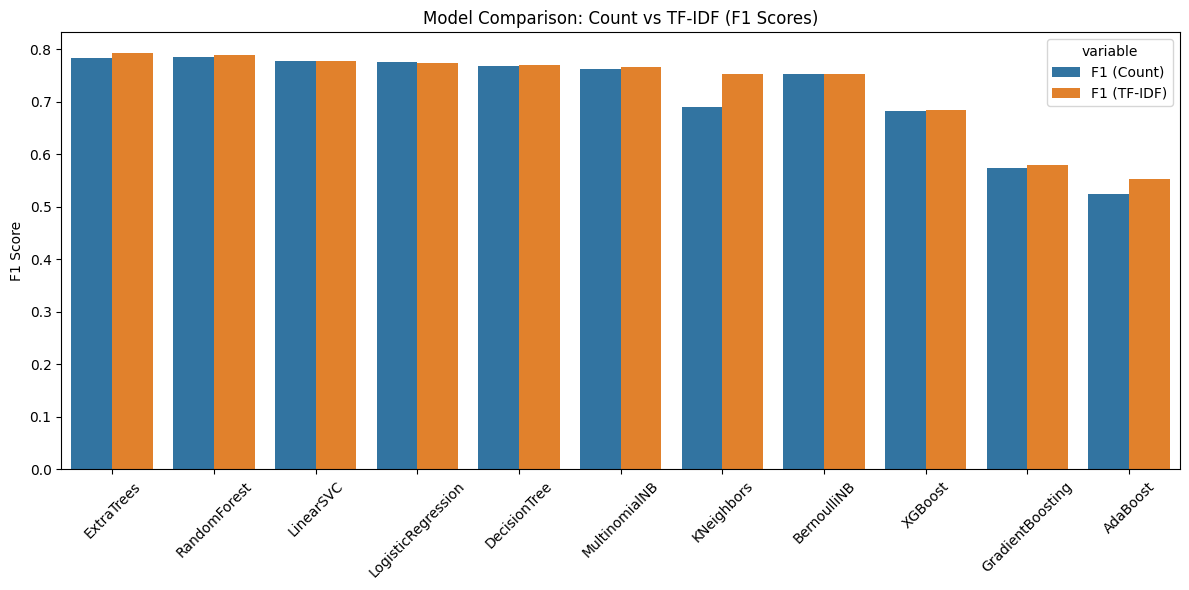

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=results_df.melt(id_vars="Model", value_vars=["F1 (Count)", "F1 (TF-IDF)"]),
            x="Model", y="value", hue="variable")
plt.xticks(rotation=45)
plt.title("Model Comparison: Count vs TF-IDF (F1 Scores)")
plt.ylabel("F1 Score")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [17]:

results_df = results_df.sort_values(by="F1 (TF-IDF)", ascending=False).reset_index(drop=True)


results_df.style.background_gradient(cmap="Blues").format({
    "Accuracy (Count)": "{:.4f}",
    "F1 (Count)": "{:.4f}",
    "Accuracy (TF-IDF)": "{:.4f}",
    "F1 (TF-IDF)": "{:.4f}",
})


,Model,Accuracy (Count),F1 (Count),Accuracy (TF-IDF),F1 (TF-IDF),Time (sec)
0,ExtraTrees,0.7878,0.7838,0.8004,0.7923,399.390000
1,RandomForest,0.7907,0.7850,0.7974,0.7885,278.580000
2,LinearSVC,0.7797,0.7767,0.7791,0.7768,22.130000
3,LogisticRegression,0.7813,0.7751,0.7784,0.7740,4.750000
4,DecisionTree,0.7716,0.7674,0.7737,0.7690,41.830000
5,MultinomialNB,0.7660,0.7619,0.7708,0.7668,0.070000
6,KNeighbors,0.7188,0.6903,0.6944,0.7524,72.060000
7,BernoulliNB,0.7684,0.7517,0.7684,0.7517,0.070000
8,XGBoost,0.7203,0.6814,0.7244,0.6840,11.580000
9,GradientBoosting,0.6582,0.5737,0.6605,0.5798,24.890000


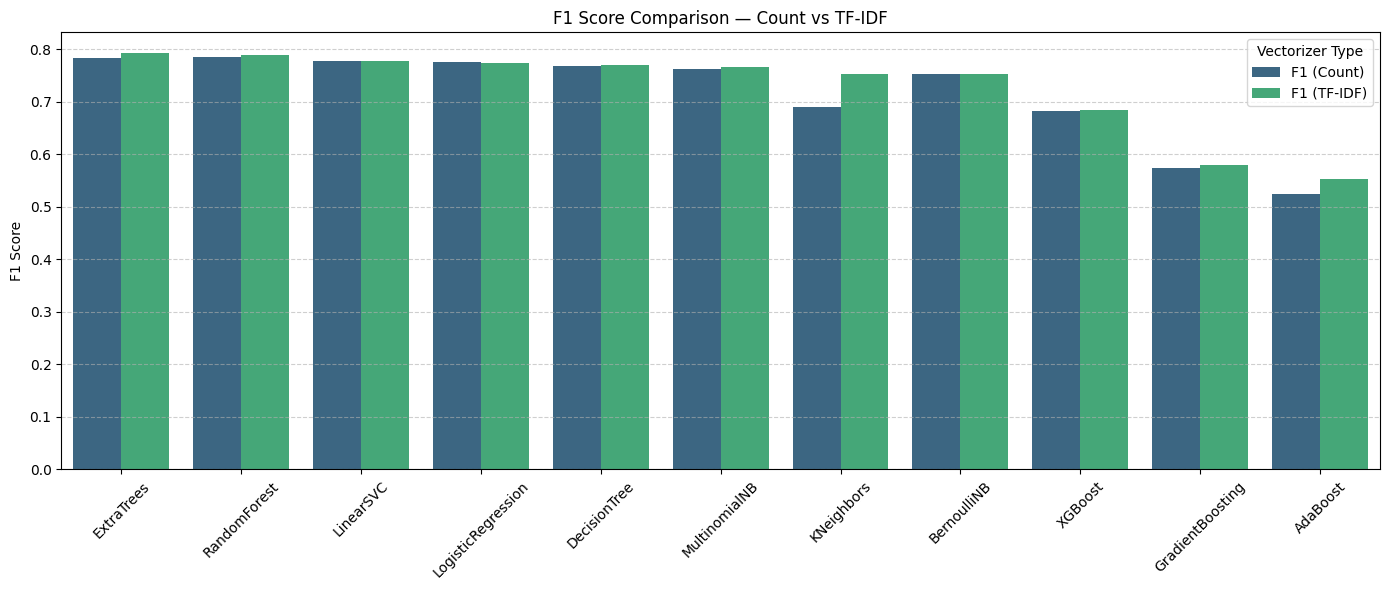

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.barplot(data=results_df.melt(id_vars="Model", value_vars=["F1 (Count)", "F1 (TF-IDF)"]),
            x="Model", y="value", hue="variable", palette="viridis")
plt.xticks(rotation=45)
plt.title("F1 Score Comparison — Count vs TF-IDF")
plt.ylabel("F1 Score")
plt.xlabel("")
plt.legend(title="Vectorizer Type")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


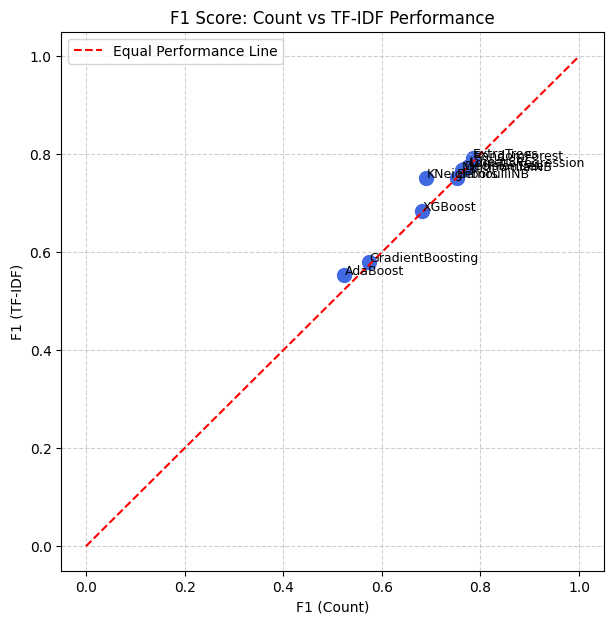

In [19]:
plt.figure(figsize=(7,7))
plt.scatter(results_df["F1 (Count)"], results_df["F1 (TF-IDF)"], s=100, color='royalblue')

for i, txt in enumerate(results_df["Model"]):
    plt.text(results_df["F1 (Count)"][i]+0.001, results_df["F1 (TF-IDF)"][i]+0.001, txt, fontsize=9)

plt.plot([0,1], [0,1], 'r--', label='Equal Performance Line')
plt.xlabel("F1 (Count)")
plt.ylabel("F1 (TF-IDF)")
plt.title("F1 Score: Count vs TF-IDF Performance")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [20]:
results_df["Average F1"] = (results_df["F1 (Count)"] + results_df["F1 (TF-IDF)"]) / 2
results_df["Best Vectorizer"] = results_df.apply(
    lambda x: "TF-IDF" if x["F1 (TF-IDF)"] > x["F1 (Count)"] else "Count", axis=1
)

overall_rank = results_df.sort_values(by="Average F1", ascending=False)

print(" (Based on Average F1):\n")
display(overall_rank[["Model", "Average F1", "Best Vectorizer"]])


 (Based on Average F1):



,Model,Average F1,Best Vectorizer
0,ExtraTrees,0.788061,TF-IDF
1,RandomForest,0.786722,TF-IDF
2,LinearSVC,0.776743,TF-IDF
3,LogisticRegression,0.774539,Count
4,DecisionTree,0.768210,TF-IDF
5,MultinomialNB,0.764331,TF-IDF
7,BernoulliNB,0.751722,Count
6,KNeighbors,0.721383,TF-IDF
8,XGBoost,0.682735,TF-IDF
9,GradientBoosting,0.576746,TF-IDF


In [21]:
best_model_row = overall_rank.iloc[0]

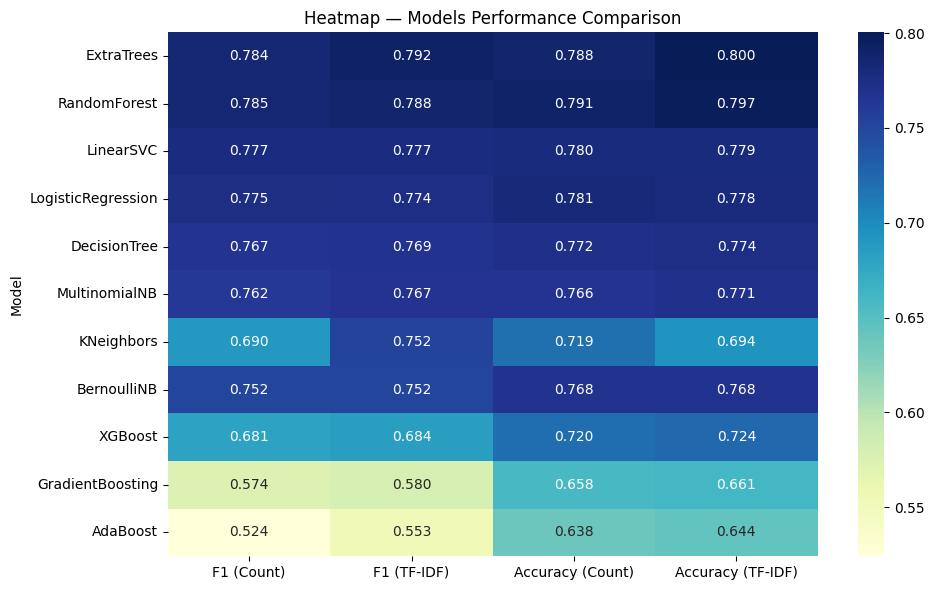

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(
    results_df.set_index("Model")[["F1 (Count)", "F1 (TF-IDF)", "Accuracy (Count)", "Accuracy (TF-IDF)"]],
    annot=True, cmap="YlGnBu", fmt=".3f"
)
plt.title("Heatmap — Models Performance Comparison")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


In [24]:
import plotly.express as px

fig = px.scatter(
    results_df,
    x="F1 (Count)",
    y="F1 (TF-IDF)",
    color="Average F1",
    text="Model",
    size="Average F1",
    title="Interactive Model Comparison (Count vs TF-IDF)",
    color_continuous_scale="Viridis"
)
fig.update_traces(textposition='top center')
fig.show()
